# Goal of the tutorial

*   Understand convolutional layers
*   Implement a convolutional neural network using Pytorch
*   Understand what a network leanrs through data reconstruction
*   Understand residual blocks and implement a residual neural network (ResNet)

# Loading the libraries and dataset

In [ ]:
# Let's load the usual libraries
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

For this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. Each class is of size 6000. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images (red, green and blue) of 32x32 pixels in size. Let's load it.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let's visualise one of the images in the dataset.

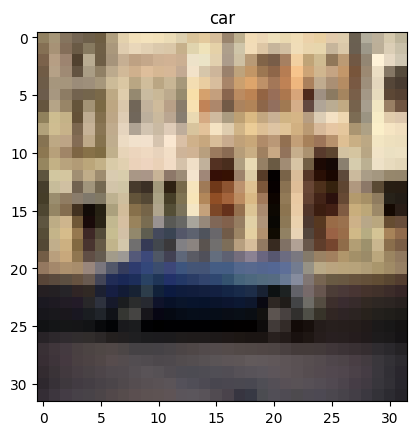

In [ ]:
# get some random training images; this will load a set of images of size batchsize
dataiter = iter(trainloader)
images, labels = next(dataiter)
img = images[0] # take just the first image; the above thing is an array of images of size batchsize
img = img / 2 + 0.5     # unnormalize

# Print the original image
npimg = img.numpy() # translate to numpy
npimg_t = np.transpose(npimg, (1, 2, 0))
plt.imshow(npimg_t)
plt.title(str(classes[labels[0]]))
plt.show()

# Implementing a Convolutional Neural Network

Let's begin by understanding convolutional layers. We will use the Pytorch conv2d function (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) to implement these. It has the following arguments:
- in_channels: the number of channels of the input
- out_channels: the number of channels we want the output to have (i.e. how many times we apply different kernels)
- kernel_size: the size of the filter
- stride: number of rows/columns traversed every time the filter is applied
- padding: size of extra pixels added at edge of image

It has some other parameters of which we will use the default modes (and hence we don't specify them):
bias = True, dilation = 1.

Remember the following:

If we have an input $I$ of size $[N, C_{in}, H, W]$, where $N$ is the number of images passed through the layer, $C_{in}$ is the number of channels each image has, and $H$ and $W$ are the height and width of the image, respectively.
The output is then computed as,
$$
O[N_n, C_{out_j}, :, :] = b[C_{out_j}] + \sum_{i=0}^{C_{in}-1} w[C_{out_j},i]*I[N_n, i, :, :].
$$

When implementing convolutional layers, it is useful to keep track of the size (height and width) of the images outputted in each layer. In the CIFAR10 dataset we use square images, so height=width.

Let us define the following:


*   $n_{in}$: height (or width) of input image
*   $k$: size of kernel
*   $p$: size of padding
*   $s$: size of stride


The height of the output image will be given by
$$
n_{out} = \left \lfloor \frac{n_{in} + 2p - k}{s} \right \rfloor + 1,
$$

where $\lfloor \cdot \rfloor$ is the floor function.

In-between conv2d layers we can apply an activation function (e.g. ReLU), batchnorm and pooling layers. Pooling layers apply an operation within a window of pixels defined by a size and a stride.

We can now define the structure of our convolutional neural network. The first part of the network will involve convolutional layers, and the second part will be made up of fully connected layers. Assume we have an input image $x$ of size $3 \times 32 \times 32$ (number of channels and image dimensions). We will use the following:
1. The input goes into a convolutional layer (3 input channels, 6 output channels, kernel of size 5x5, stride 1, padding 1), followed by a ReLU activation and maxpool layer (size 2, stride 2)
2. The output from the previous operation goes into another convolutional layer (6 input channels, 16 output channels, kernel of size 5x5, stride 2, padding 1) followed by ReLU
3. Then there will be two linear layer + ReLU's and a final linear layer.





In [ ]:
class Net(nn.Module):
    # in the init function we will just define several layers that we can later use
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=1) # convolutional layer
        # what is the size of the object after the above convolution? original image is 32x32; after convolution
        # it will be floor((32 + 2*1 - 5)/1) + 1 = 30 -> 30x30

        # a pooling layer: it 'pools' together 2x2 of the inputs by keeping only the maximum value
        # and uses a stride of 2
        self.pool = nn.MaxPool2d(2, stride=2)
        # after pooling size is 15x15 (see: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=2, padding=1) # convolutional layer
        # size after convolution: floor((15 + 2*1 - 5)/2) + 1 = 7 -> 7x7

        self.fc1 = nn.Linear(16 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    # here we define the forward pass, i.e. how our input x is modified as it moves through the network
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # size after operation: 15x15
        x = F.relu(self.conv2(x)) # size after operation: 7x7
        x = torch.flatten(x, 1) # flatten all dimensions except batch; size is 16*7*7
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

Let's write a training function:

In [ ]:
def train(model, nr_epochs, optimizer, criterion):
    losses = [] # store the losses

    for epoch in range(0, nr_epochs):
        print(f'Epoch {epoch}')
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            images, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # Compute the output for all the images in the batch_size; remember we set a batch_size of 10 in the beginning!
            outputs = model(images)
            # Compute the loss value
            loss = criterion(outputs, labels)
            # Compute the gradients
            loss.backward()
            # Take the optimisation step
            optimizer.step()

            # print statistics
            losses += [loss.item()]
            if i % 100 == 0:    # print every 1000 iterations
                print(i, loss.item())

    print('Finished Training')

In [ ]:
train(model=net, nr_epochs=20, optimizer=optim.SGD(net.parameters(), lr=0.01, momentum=0.9), criterion=nn.CrossEntropyLoss())

Epoch 0
0 2.3142762184143066
100 2.296750783920288
200 2.1375272274017334
300 1.8368284702301025
Epoch 1
0 1.7357410192489624
100 1.4649178981781006
200 1.524221420288086
300 1.5408951044082642
Epoch 2
0 1.217059850692749
100 1.3625704050064087
200 1.255933165550232
300 1.267778754234314
Epoch 3
0 1.2829068899154663
100 1.0959336757659912
200 1.1983723640441895
300 1.2289085388183594
Epoch 4
0 1.0828533172607422
100 0.9859827756881714
200 1.0483819246292114
300 0.9578251838684082
Epoch 5
0 0.9562321901321411
100 0.7473869919776917
200 1.0414830446243286
300 0.9195214509963989
Epoch 6
0 0.7300156354904175
100 0.8798450231552124
200 0.8032562732696533
300 0.925108790397644
Epoch 7
0 0.6963276863098145
100 0.8076794147491455
200 0.8209925293922424
300 0.6361995935440063
Epoch 8
0 0.6255615949630737
100 0.548670768737793
200 0.8763428926467896
300 0.531999945640564
Epoch 9
0 0.5377205610275269
100 0.44269779324531555
200 0.6415829658508301
300 0.62213134765625
Epoch 10
0 0.4175812304019928

We can now evaluate the model on test data.

In [ ]:
def accuracy(model):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs; therefore there
    # is no need to store the computational graph in between
    with torch.no_grad():
        for data in testloader: #iterate over all the test images
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            # compute the total number of images processed by adding the number of images in each batch
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct // total} %')

In [ ]:
accuracy(net)

Accuracy of the network on the test images: 64 %


## Task: implement your own Convolutional Neural Network

Change the architecture, number of batches (we defined this when we loaded the data in one of the first cells) and number of epochs to see how this changes what the network has learned.

Remember: machine learning is quite tricky with lots of hyperparameter tuning required. A large part of the job is trying to find the right combinations of parameters that work.

# Understanding what our network has learned

For this part, we will use the following larger model:

In [ ]:
class Net(nn.Module):
    # in the init function we will just define several layers that we can later use
    def __init__(self):
        super().__init__()
        #parameters: in_channels, out_channels, kernel_size
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.conv4 = nn.Conv2d(256, 256, 3)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.fc1 = nn.Linear(1024, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    # here we define the forward pass, i.e. how our input x is modified as it moves through the network
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    # let's also define a method to access a layer of choice's output; we will use this later
    def forward_partial(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        return x # you can change the partial forward pass to obtain arbitrary layers' output

Let's train the model.

In [ ]:
net = Net()
train(model=net, nr_epochs=5, optimizer=optim.SGD(net.parameters(), lr=0.01, momentum=0.9), criterion=nn.CrossEntropyLoss())

Epoch 0
0 2.310192346572876
100 2.3036625385284424
200 2.3010897636413574
300 2.2942724227905273
Epoch 1
0 2.126641273498535
100 1.9078365564346313
200 1.6684809923171997
300 1.6572669744491577
Epoch 2
0 1.6440539360046387
100 1.5038261413574219
200 1.3890857696533203
300 1.4128164052963257
Epoch 3
0 1.5087521076202393
100 1.2315822839736938
200 1.06552255153656
300 1.2389559745788574
Epoch 4
0 1.1747833490371704
100 1.0325393676757812
200 0.9420652389526367
300 1.130104660987854
Finished Training


In [ ]:
accuracy(net)

Accuracy of the network on the test images: 62 %


Now, we would like to understand what the network has actually learned. The work in: https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html does something similar, so check it out if you're interested.

Consider that we pass a certain image $\tilde x$ through the network and get the output $z^n$ from the neural network.

Based on that output we would like to reconstruct the input to better understand how well our neural network has learned the original image. Denote with $\hat z^n$ the output from the same layer for some input $x$.

Consider then the squared error loss
$$
\mathcal{L}(z^n, \hat z^n) = ||z^n-\hat z^n||_2^2,
$$

We will give the network a certain input image $\tilde x$ and obtain the layer values for that image $z^n$. We assume we only observe $z^n$, but want to *reconstruct* $\tilde x$. To do that we will optimise over the $x$ that gets us as close as possible to that layer output:
$$
x^* = \arg\min_{x} \mathcal{L}(z^n, \hat z^n).
$$

We will further follow the work of https://arxiv.org/pdf/1412.0035v1.pdf

It can be useful to restrict the reconstruction to the subset of natural images - in order to make the above reconstruction better (and easier to interpret). In order to do so, we need to define the properties that natural images have. A proxy used in the above paper is to incorporate in the reconstruction an appropriate image prior. As in the paper, we will try two things:

1. the $\alpha$-norm: $R(x) = ||x||_{\alpha}^{\alpha}$ where $x$ is the vectorised and meansubtracted image. With this regularisation we force the image values to stay within a certain range.

2. the total variation encouraging images to consist of piece-wise constant patches: $R(x) = \sum_{i,j} \left((x_{i,j+1}-x_{ij})^2 + (x_{i+1,j}-x_{ij})^2\right)^{\frac{\beta}{2}}$ where $x\in\mathbb{R}^{H\times W}$ with $H$ the height and $W$ the width.

We will add the above terms as regularisers to our loss function.

In [ ]:
# Define our new criteria:
def R_1(img, alpha):
    img = torch.flatten(img)
    R1 = torch.linalg.norm(img, ord=alpha)
    return R1

def R_2(img, beta):
    R2 = torch.sum(torch.pow(torch.flatten(torch.pow(img[:,:,:,1:] - img[:,:,:,:-1], 2)) \
                                + torch.flatten(torch.pow(img[:,:,1:,:] - img[:,:,:-1,:], 2)), beta/2))
    return R2

# Load a new batch of data
dataiter = iter(trainloader)

Let us now implement the optimisation scheme. We will begin by initialising a random image, then minimising the loss criterion that we discussed above.

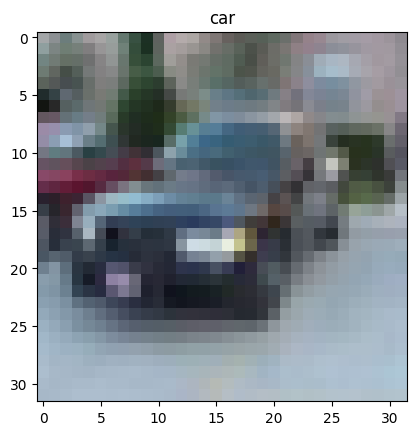

278.6651611328125
149.21713256835938
148.38604736328125
144.08413696289062
143.45436096191406
145.68783569335938
142.61895751953125
138.80938720703125
143.99896240234375
148.76458740234375
143.81788635253906
146.4933624267578
143.70599365234375
148.2956085205078
148.1767120361328
145.30648803710938
144.6696014404297
145.7045440673828
144.6616668701172
145.41616821289062


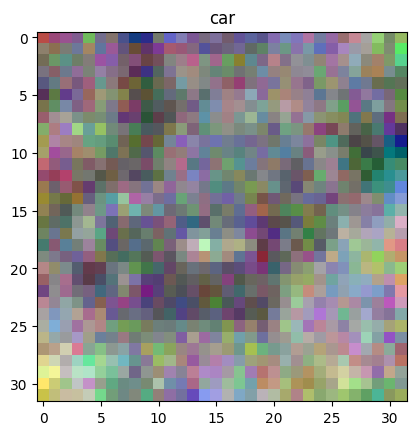

In [ ]:
# Get some image
images, labels = next(dataiter)
img = images[0] # take just the first image; the above thing is an array of images of size batchsize
img = img / 2 + 0.5     # unnormalize

# Print the original image
npimg = img.numpy() # translate to numpy
npimg_t = np.transpose(npimg, (1, 2, 0)) # transpose things
plt.imshow(npimg_t)
plt.title(str(classes[labels[0]]))
plt.show()

# Pas the image through the network and get the layer output
true_out = net.forward_partial(images[0:1,:,:,:])

# Optimize the output from the layer for some random input to get close to the output for the original image
sample_image = torch.rand(1, 3, 32, 32)
sample_image.requires_grad = True
nr_its_in = 100000
lr = 0.0001
for it in range(nr_its_in):
    sample_out = net.forward_partial(sample_image)
    sample_loss = torch.sum(torch.pow(true_out.detach() - sample_out, 2)) \
            + 0.05 * R_1(sample_image, 6) + 0.1 * R_2(sample_image, beta=2)
    sample_loss.backward()
    # Perform the gradient step to improve the sample_image
    with torch.no_grad():
        sample_image -= lr*sample_image.grad #+ 0.001*torch.rand(sample_image.shape)
    if it%5000==0:
        print(sample_loss.item())

# Print reconstructed image
numpy_image = sample_image.detach().numpy()
# Constrain to the right range
numpy_image += np.abs(numpy_image.min())
numpy_image /= numpy_image.max()
numpy_image = np.transpose(numpy_image[0,:,:,:], (1, 2, 0))
plt.imshow(numpy_image)
plt.title(classes[labels[0]])
plt.show()

Run the above code multiple times - for certain images the reconstruction works better than for others.

## Task:
Try to change the layer whose output we use. You can do this by modifying the forward_partial function we defined in the neural network class. Are any particular layers better at reconstructing the image? The later the layer you choose, the worse the reconstruction typically as later layers contain more high-level information.

Also try to add or remove the noise - is there any difference in training with noise? Try also changing the parameters to see if you can find a configuration which obtains better results than what I managed to obtain.

What do you think of the above? We can in general reconstruct something even with our relatively simple model (compared to the architectures Google and so on use). What if the input image contained sensitive information? Can you think that the above is a privacy or security risk?

# ResNet

Let's now try to code a different model. We will follow the architecture of ResNet (see https://arxiv.org/pdf/1512.03385.pdf), which has had a significant impact on the architectures we use in many models due to introducing the idea of skip connections.

ResNet is divided into building blocks called Residual blocks, which are made up of convolutional layers. Let $F$ define a non-linear mapping (such as a sequence of convolutional layers, activation functions, etc.). CNNs such as the previous one we coded would typically model the output of a collection of convolutional layers as
$$
x_{l+1} = F(x_l).
$$
ResNet adds the input to the output of the block, so that
$$
x_{l+1} = x_l + F(x_l).
$$
This identity addition is what we call a **skip connection**. Note that it does not add computational complexity to $F$. When we apply backpropagation on the Residual block, we obtain
$$
\frac{\partial x_{l+1}}{\partial x_l} = I + \frac{\partial F}{\partial x_l},
$$
where $I$ is the identity matrix, instead of
$$
\frac{\partial x_{l+1}}{\partial x_l} = \frac{\partial F}{\partial x_l}.
$$



##Residual Blocks

Let's begin by coding a residual block. Let $x$ be the input to the residual block. The structure of the residual blocks will be:

 input -> convolutional layer 1 -> batchnorm -> ReLU -> convolutional layer 2 -> batchnorm + input -> ReLU.

Before applying the ReLU activation function after the second convolutional layer, we add the input of the block to the output (we call this the residual). **The parameters of the residual blocks are defined in order to either preserve or decrease the dimensions (height and width) of the input.** If the dimensions are preserved, then we can simply add the input at the end of the residual block, if the dimensions are decreased, we also downsample the input so that the dimensions match.

Parameters:
*   in_channels: number of input channels into residual block
*   out_channels: number of output channels out of residual block
*   stride: size of stride of **first convolutional layer** (this layer will determine if the output of the residual block has the same dimensionality or different to the input)
*   reduce_dim: this is a boolean to define if we want to reduce the dimensionality of the input or not. If so, we will apply a 1x1 convolution with stride 2

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, reduce_dim=False):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1) # first convolutional layer
        # size after convolution: n_out = floor((n_in + 2*1 - 3)/stride) + 1
        # check that when stride=1 n_out = n_in, when stride=2 n_out = floor((n_in - 1)/2) + 1

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1) # second convolutional layer
        # size after convolution: n_out = floor((n_in + 2*1 - 3)/1) + 1 = n_in so size is preserved

        self.reduce_dim = reduce_dim
        self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 2, padding = 0) # convolutional layer to reduce dimensionality of the input
        # size after convolution: n_out = floor((n_in - 1)/2) + 1
        # this is the same dimensionality as what we obtain after applying conv1 with stride=2 followed by conv2

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.reduce_dim: # if after conv1 the dimensionality is changed, we apply downsample in order for dim(residual) and dim(out) to match
            residual = self.downsample(x)
        out += residual # add input (this is the skip connection)
        out = self.relu(out)
        return out

## Architecture

The ResNet architecture consists of input convolutional layers, groups of Residual Blocks and some output linear layers.

Input layers -> Residual blocks -> Output layers

Of all the Residual Blocks, only some of them will reduce the dimensionality of the input. For example, if ResNet has [3, 3, 3] blocks, then we have 3 times a group of 3 blocks. **Dimensionality reduction will occur in the first residual block of each group, excluding the first group.** In the case of [3, 3, 3] dimensionality reduction occurs in the fourth and seventh residual blocks. ResNets are usually implemented with more residual blocks (that show a better performance), however we will code a smaller version with the structure [3, 3, 3].

Structure of input layers:

1.   Convolutional layer (3 input channels, 32 output channels, kernel of size 7x7, stride 2, padding 3), followed by batchnorm and a ReLU activation
2.   Maxpool (kernel of size 3x3, stride 2, padding 1)

Structure of output layers:

1.   Averagepool (kernel of size 2x2, , stride 1, padding 0)
2.   Linear layer

We will use the function _make_group to add the groups of residual blocks described above.

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, groups, num_classes = 10):
        super(ResNet, self).__init__()
        self.block = block

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=2, padding=3)
        self.bn = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.inplanes = 32 # define the number of channels of the input of the first residual block (this will be updated as the residual blocks are added to the network)

        # groups of residual blocks
        self.group0 = self._make_group(block, 32, groups[0], stride = 1)
        self.group1 = self._make_group(block, 64, groups[1], stride = 2)
        self.group2 = self._make_group(block, 128, groups[2], stride = 2)

        self.avgpool = nn.AvgPool2d(2, stride=1)
        self.fc = nn.Linear(128, num_classes)

    def _make_group(self, block, planes, blocks, stride=1):
        '''
        block: residual block used in model
        planes: int, number of channels the output of group should have
        stride: int, size of stride of first convolutional layer of first residual block in group
        '''
        reduce_dim=False

        # first residual block in group
        if stride != 1 or self.inplanes != planes: # we reduce dimensionality when stride=2 or if the input and output channels into the residual block do not match
            reduce_dim=True
        group = []
        group.append(block(self.inplanes, planes, stride, reduce_dim)) # add residual block to list
        self.inplanes = planes # update number of channels of input to next residual block (according to output of current residual block)

        # remaining residual blocks in group
        for i in range(1, blocks):
            group.append(block(self.inplanes, planes))

        return nn.Sequential(*group)


    def forward(self, x):
        # input layers
        x = self.conv1(x)
        if self.block.__class__.__name__ == 'ResidualBlock':
            x = self.relu(self.bn(x))
        x = self.maxpool(x)

        # groups of residual blocks
        x = self.group0(x)
        x = self.group1(x)
        x = self.group2(x)

        # output layers
        x = self.avgpool(x)
        x = x.view(x.size(0), -1) # flatten all dimensions except batch
        x = self.fc(x)

        return x

Let's train the model. You can also compare different architectures (instead of [3, 3, 3]) to see what produces the best accuracy.

In [ ]:
resnet = ResNet(block=ResidualBlock, groups=[3, 3, 3]) # total number of residual blocks is 9
train(model=resnet.train(), nr_epochs=15, optimizer=optim.SGD(resnet.parameters(), lr=0.01, momentum = 0.9), criterion=nn.CrossEntropyLoss())

Epoch 0
0 2.7006585597991943
100 1.646323561668396
200 1.6925228834152222
300 1.4686644077301025
Epoch 1
0 1.007996678352356
100 1.1722428798675537
200 1.057021975517273
300 1.157109022140503
Epoch 2
0 0.8787276744842529
100 0.841263473033905
200 1.0776599645614624
300 1.0899314880371094
Epoch 3
0 0.8290098905563354
100 0.7413892149925232
200 0.8711803555488586
300 0.815237283706665
Epoch 4
0 0.779363214969635
100 0.6569690704345703
200 0.7452593445777893
300 0.6180649399757385
Epoch 5
0 0.6159049868583679
100 0.6607245206832886
200 0.5232887268066406
300 0.7348923683166504
Epoch 6
0 0.6929875016212463
100 0.4223068058490753
200 0.539080798625946
300 0.5289671421051025
Epoch 7
0 0.4681061804294586
100 0.5725924968719482
200 0.5854639410972595
300 0.6109017133712769
Epoch 8
0 0.34027671813964844
100 0.5185897946357727
200 0.5975741744041443
300 0.3710200786590576
Epoch 9
0 0.4726373553276062
100 0.4898390471935272
200 0.41906842589378357
300 0.4875931143760681
Epoch 10
0 0.3056833446025

Let's evaluate the ResNet on the test set. We can compare the performance to the previous CNN we coded.

In [ ]:
accuracy(resnet.eval())

Accuracy of the network on the test images: 72 %


## Task: implement Pre-Activation Residual Blocks

One of the variants of ResNet involves using Residual Blocks with a different architecture. Let's look at Pre-Activation Residual Blocks. In the original model, the activation function (in our case the ReLU function) is applied after the skip connection. In the pre-activation variant, the batchnorm and ReLU function are applied **at the beginning of the residual block**:

input -> batchnorm -> ReLU -> convolutional layer 1 -> batchnorm -> ReLU -> convolutional layer 2 + input

Note that the input layers of ResNet will have to be modified: the batchnorm and ReLU in the input layers will have to be removed in order to not be applied twice.

In [ ]:
class PreActivationResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, reduce_dim=False):
        super(PreActivationResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1) # first convolutional layer
        # size after convolution: n_out = floor((n_in + 2*1 - 3)/stride) + 1
        # check that when stride=1 n_out=n_in, when stride=2 n_out=floor(n_out/2)+1

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1) # second convolutional layer
        # size after convolution: n_out = floor((n_in + 2*1 - 3)/1) + 1 = n_in so size is preserved

        self.reduce_dim = reduce_dim
        self.downsample = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 2, padding = 0) # convolutional layer to reduce dimensionality of the input
        # size after convolution: n_out = floor((n_in - 1)/2) + 1 = floor(n_out/2) + 1
        # check that this is the same dimensionality as after applying conv1 with stride=2 and conv2

        self.bn1 = nn.BatchNorm2d(in_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(x))
        out = self.relu(self.bn2(self.conv1(out)))
        out = self.conv2(out)
        if self.reduce_dim: # if after conv1 the dimensionality is changed, we apply downsample in order for dim(residual) and dim(out) to match
            residual = self.downsample(x)
        out += residual # add input (this is the skip connection)
        return out

In [ ]:
pre_act_resnet = ResNet(block=PreActivationResidualBlock, groups=[3, 3, 3])
train(model=pre_act_resnet.train(), nr_epochs=15, optimizer=optim.SGD(pre_act_resnet.parameters(), lr=0.01, momentum = 0.9), criterion=nn.CrossEntropyLoss())

Epoch 0
0 2.343829393386841
100 1.4880532026290894
200 1.5343586206436157
300 1.1441653966903687
Epoch 1
0 1.088971734046936
100 1.0153623819351196
200 0.9611711502075195
300 1.0070812702178955
Epoch 2
0 0.8358744978904724
100 0.8633841276168823
200 0.9226250052452087
300 0.947117030620575
Epoch 3
0 0.5879146456718445
100 0.847430944442749
200 0.720920205116272
300 0.8318880796432495
Epoch 4
0 0.6074342727661133
100 0.8225787878036499
200 0.5630785822868347
300 0.7273276448249817
Epoch 5
0 0.4659854471683502
100 0.3952975571155548
200 0.634455680847168
300 0.5734705924987793
Epoch 6
0 0.41432467103004456
100 0.6378262042999268
200 0.49673882126808167
300 0.4218764305114746
Epoch 7
0 0.4052400588989258
100 0.3124157786369324
200 0.4832579493522644
300 0.41669490933418274
Epoch 8
0 0.3399214744567871
100 0.32855021953582764
200 0.39077067375183105
300 0.3357105851173401
Epoch 9
0 0.18790952861309052
100 0.1836286038160324
200 0.3811541795730591
300 0.4694831073284149
Epoch 10
0 0.2458101

In [ ]:
accuracy(pre_act_resnet.eval())

Accuracy of the network on the test images: 71 %


The Pre-activation ResNet has been shown to perform better than the original ResNet for very deep networks. Is the same true in our shallow setting?

Feel free to experiment with other structures of residual blocks (see Figure 4 in https://arxiv.org/pdf/1603.05027.pdf).

# References



*   Aravindh Mahendran and Andrea Vedaldi (2014). Understanding deep image representations by inverting them. Arxiv: https://arxiv.org/abs/1412.0035
*   Kaiming He, Xiangyu Zhang, Shaoqing Ren and Jian SunDeep (2015). Residual Learning for Image Recognition. Arxiv: https://arxiv.org/pdf/1512.03385.pdf
*   Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun (2016). Identity Mappings in Deep Residual Networks. Arxiv: https://arxiv.org/pdf/1603.05027.pdf
*   https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/
*   https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html#ResNet

